# Statistical analysis of Experiment

## Import

Let's start by importing the neccesary libraries, and loading in the responses.

In [ ]:
!pip install -U kaleido krippendorff

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from typing import Dict
import numpy as np
import re
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
import krippendorff
import seaborn as sns
from scipy.stats import ttest_ind

pd.options.plotting.backend = "plotly"

In [ ]:
df_test = pd.read_csv('https://raw.githubusercontent.com/jlwbr/naturalness_eval/main/experiment/sentences.csv')
df_test = df_test[df_test["Class"] != 0]
df_test.head()

,Formula,Translation,Translation_Type,Class,Difference,length
16,"~ FrontOf ( d , c ) & ~ FrontOf ( d , b ) & ~ ...",It is not the case that d is in front of c and...,Baseline,1,False,38
17,"~ / v ( RightOf ( v , b ) & Cube ( v ) )",It is not the case that there is an element v ...,Baseline,1,False,25
18,~ / x ( Cube ( x ) & @ y ( Tet ( y ) $ FrontOf...,It is not the case that there is an element x ...,Ranta,1,True,29
19,"~ / u ( LeftOf ( b , u ) & Cube ( u ) )",It is not the case that there is an element u ...,Baseline,1,False,25
20,"@ x ( Cube ( x ) $ / y ( RightOf ( y , x ) & ~...","For all x, if x is a cube, then there is an el...",Baseline,1,False,43


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/jlwbr/naturalness_eval/main/experiment/responses.csv")
df = df.iloc[2:]
df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,91_Q14_1,91_Q15_1,92_Q14_1,92_Q15_1,93_Q14_1,93_Q15_1,94_Q14_1,94_Q15_1,95_Q14_1,95_Q15_1
2,2024-01-17 14:47:30,2024-01-17 15:00:44,IP Address,*******,100,793,True,2024-01-17 15:00:45,R_6V7UFpvD9k2d8fX,*******,...,2.5,6,2.6,6,2.6,6,2.6,6,2.9,7
3,2024-01-18 06:21:42,2024-01-18 06:34:15,IP Address,*******,100,752,True,2024-01-18 06:34:16,R_6zCrfUGTGGX6uJK,*******,...,3,7,1.2,7,3,7,3,7,3,7
4,2024-01-18 08:45:40,2024-01-18 09:04:03,IP Address,*******,100,1102,True,2024-01-18 09:04:04,R_1uHXlrD9tGNCX1g,*******,...,3,7,3,3,3,7,3,7,3,7
5,2024-01-18 14:26:33,2024-01-18 14:40:29,IP Address,*******,100,835,True,2024-01-18 14:40:29,R_72RSm94scENw98Z,*******,...,3,7,3,6,3,7,3,7,3,7
6,2024-01-20 01:39:57,2024-01-20 01:50:37,IP Address,*******,100,640,True,2024-01-20 01:50:38,R_5EEFg1PoytSByHJ,*******,...,3,7,2.9,7,3,7,3,7,3,7


## Demographics

Now, lets analyse the questions about demographics

In [ ]:
print("Age:")
print(df['Q1'].value_counts())
print("\nSex:")
print(df['Q2'].value_counts(normalize=True))
print("\nEducation:")
print(df['Q3'].value_counts(normalize=True))
print("\nProficiency:")
print("English:", df['Q4_1'].astype(float).mean(), "std:", df['Q4_1'].astype(float).std())
print("Linguistics:", df['Q4_2'].astype(float).mean(), "std:", df['Q4_2'].astype(float).std())
print("Logic:", df['Q4_3'].astype(float).mean(), "std:", df['Q4_3'].astype(float).std())

Age:
18-24 years old    4
45-54 years old    2
35-44 years old    1
25-34 years old    1
Name: Q1, dtype: int64

Sex:
Female    0.5
Male      0.5
Name: Q2, dtype: float64

Education:
Some university but no degree                                           0.375
Graduate or professional degree (MA, MS, MBA, PhD, JD, MD, DDS etc.)    0.375
Vocational or Similar                                                   0.250
Name: Q3, dtype: float64

Proficiency:
English: 6.875 std: 1.1259916264596033
Linguistics: 5.5 std: 1.1952286093343936
Logic: 7.5 std: 2.0


## Extract scores

Now, we extract the scores from the dataset.

In [ ]:
cols = df.columns.tolist()

gramaticality_cols: Dict[str, str] = {}
formulaicness_cols: Dict[str, str]= {}

for col in cols:
    result = re.match('(\\d+)_Q14_1', col)
    if result:
        formulaicness_cols[result.group(1)] = col

    result = re.match('(\\d+)_Q15_1', col)
    if result:
        gramaticality_cols[result.group(1)] = col

gramaticality_df = df[gramaticality_cols.values()]
formulaicness_df = df[formulaicness_cols.values()]

index = pd.MultiIndex.from_tuples(
    zip(df_test["Class"], gramaticality_cols.keys()),
    names=['class', 'sentence']
)

gramaticality_df.columns = index
formulaicness_df.columns = index

gramaticality_df = gramaticality_df.apply(pd.to_numeric).reset_index(drop=True)
formulaicness_df = formulaicness_df.apply(pd.to_numeric).reset_index(drop=True)

## Annotator agreement

Let's see if our annotators agree with each other.

## Krippendorff's alpha

Krippendorff's alpha shows us how well annotators agee with each other.

In [ ]:
krippendorff_alpha_gram = krippendorff.alpha(reliability_data=gramaticality_df.values, level_of_measurement='ordinal')
krippendorff_alpha_form = krippendorff.alpha(reliability_data=formulaicness_df.values, level_of_measurement='ordinal')

print("Krippendorff's alpha grammaticality:", krippendorff_alpha_gram)
print("Krippendorff's alpha formulaicness:", krippendorff_alpha_form)

Krippendorff's alpha grammaticality: 0.28543084500218796
Krippendorff's alpha formulaicness: 0.4388008691230426


## Correlations

Now we import the results from the experiment and build visualizations

In [ ]:
results = pd.read_csv("https://raw.githubusercontent.com/jlwbr/naturalness_eval/main/experiment/results.csv")
results["class"] = results["class"].astype(str)
results["translation"] = df_test["Translation"].reset_index(drop=True)
results = results.drop(columns=["Final"])
res = results.melt(id_vars=["class",  "translation", "sentence", "Grammaticality", "Formulaicness"], value_name="Model Score")

res

,class,translation,sentence,Grammaticality,Formulaicness,variable,Model Score
0,1,It is not the case that d is in front of c and...,48,3.750,1.6500,GRUEN,0.724352
1,1,It is not the case that there is an element v ...,49,4.375,1.8500,GRUEN,0.788384
2,1,It is not the case that there is an element x ...,50,4.500,1.7750,GRUEN,0.705330
3,1,It is not the case that there is an element u ...,51,4.250,1.8125,GRUEN,0.772378
4,1,"For all x, if x is a cube, then there is an el...",52,4.375,1.7750,GRUEN,0.812203
...,...,...,...,...,...,...,...
139,3,"A metal is magnetic, a gas is compressible, an...",91,6.250,2.6875,Combined Model,0.878344
140,3,A smartphone is user-friendly when it has an i...,92,5.625,2.7000,Combined Model,0.670726
141,3,Vehicles offering excellent fuel efficiency an...,93,6.125,2.7750,Combined Model,0.754350
142,3,A cake is ready to be removed from the oven wh...,94,6.375,2.9375,Combined Model,0.837858


In [ ]:
filtered = res[res['variable'] != "Formulaicness Model"]

fig = filtered.plot(kind='scatter', x='Grammaticality', y='Model Score', color="class", symbol="class", hover_data=["translation"], facet_col="variable", trendline="ols")
fig2 = filtered.plot(kind='scatter', x='Grammaticality', y='Model Score', hover_data=["translation"], facet_col="variable", trendline="ols")

col = 1
for trace in range(len(fig2["data"])):
  trace = fig2["data"][trace]
  if trace.mode == "lines":
    trace.update(line_color="#19d3f3", legendgroup="Overall Trendline", name="Overall Trendline", showlegend=(col == 1))
    fig.append_trace(trace, row=1, col=col)
    col += 1

fig.update_traces(marker_size=5)

fig.show()

In [ ]:
fig = results.plot(kind='scatter', x='Formulaicness', y='Formulaicness Model', color="class", symbol="class", hover_data=["translation"], trendline="ols")
fig2 = results.plot(kind='scatter', x='Formulaicness', y='Formulaicness Model', hover_data=["translation"], trendline="ols")

col = 1
for trace in range(len(fig2["data"])):
  trace = fig2["data"][trace]
  if trace.mode == "lines":
    trace.update(line_color="#19d3f3", legendgroup="Overall Trendline", name="Overall Trendline", showlegend=(col == 1))
    fig.append_trace(trace, row=1, col=col)
    col += 1

fig.update_traces(marker_size=5)

fig.show()

The below tables show all different correlations between the different variables

In [ ]:
results.drop(["sentence"], axis=1).corr(method='pearson', numeric_only=True)

,Grammaticality,Formulaicness,GRUEN,Formulaicness Model,Combined Model
Grammaticality,1.000000,0.891322,0.448521,0.617965,0.670861
Formulaicness,0.891322,1.000000,0.240380,0.649868,0.658881
GRUEN,0.448521,0.240380,1.000000,0.203520,0.392706
Formulaicness Model,0.617965,0.649868,0.203520,1.000000,0.980340
Combined Model,0.670861,0.658881,0.392706,0.980340,1.000000


In [ ]:
results.drop(["sentence"], axis=1).corr(method='kendall', numeric_only=True)

,Grammaticality,Formulaicness,GRUEN,Formulaicness Model,Combined Model
Grammaticality,1.000000,0.586298,0.357049,0.458288,0.516139
Formulaicness,0.586298,1.000000,0.133932,0.394653,0.416082
GRUEN,0.357049,0.133932,1.000000,0.205674,0.400709
Formulaicness Model,0.458288,0.394653,0.205674,1.000000,0.804965
Combined Model,0.516139,0.416082,0.400709,0.804965,1.000000


In [ ]:
results.drop(["sentence"], axis=1).corr(method='spearman', numeric_only=True)

,Grammaticality,Formulaicness,GRUEN,Formulaicness Model,Combined Model
Grammaticality,1.000000,0.771134,0.497187,0.650824,0.710212
Formulaicness,0.771134,1.000000,0.209949,0.549310,0.569730
GRUEN,0.497187,0.209949,1.000000,0.300152,0.492401
Formulaicness Model,0.650824,0.549310,0.300152,1.000000,0.939752
Combined Model,0.710212,0.569730,0.492401,0.939752,1.000000


<Axes: >

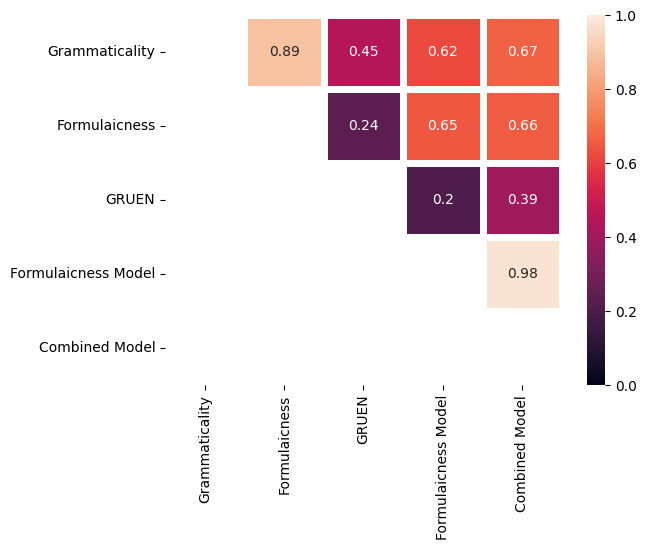

In [ ]:
corr = results.drop(["sentence"], axis=1).corr(method='pearson', numeric_only=True)

sns.heatmap(
    corr,
    mask=np.tri(len(corr)),
    annot=True, linewidths=5,
    vmin=0, vmax=1,
)


In [ ]:
results.plot(kind='scatter', x="Formulaicness Model", y="Combined Model")

In [ ]:
results.plot(kind='scatter', x="GRUEN", y="Combined Model")

## T-tests

The below code shows t-tests between class 1 and 2, and class 3, for  the Formulaicness model, Formulaicness score, Grammaticality score, and Combined model.

In [ ]:
print(results[results["class"].isin(["1", "2"])]["Formulaicness"].mean())
print(results[results["class"].isin(["1", "2"])]["Formulaicness"].sem())
print(results[results["class"] == "3"]["Formulaicness"].mean())
print(results[results["class"] == "3"]["Formulaicness"].sem())

print(ttest_ind(results[results["class"] == "3"]["Formulaicness"], results[results["class"].isin(["1", "2"])]["Formulaicness"], equal_var=False))

print(results[results["class"].isin(["1", "2"])]["Formulaicness Model"].mean())
print(results[results["class"].isin(["1", "2"])]["Formulaicness Model"].sem())
print(results[results["class"] == "3"]["Formulaicness Model"].mean())
print(results[results["class"] == "3"]["Formulaicness Model"].sem())

print(ttest_ind(results[results["class"] == "3"]["Formulaicness Model"], results[results["class"].isin(["1", "2"])]["Formulaicness Model"], equal_var=False))

1.7781250000000002
0.03213955676220454
2.79140625
0.035368571817304614
TtestResult(statistic=21.202774865889197, pvalue=1.639669741486969e-22, df=37.59605671257607)
0.19514114521048698
0.05142143534923261
0.6979035011857713
0.08095627461965227
TtestResult(statistic=5.242206256944868, pvalue=1.5249978296832594e-05, df=27.387920680469062)


In [ ]:
print(results[results["class"].isin(["1", "2"])]["Grammaticality"].mean())
print(results[results["class"].isin(["1", "2"])]["Grammaticality"].sem())
print(results[results["class"] == "3"]["Grammaticality"].mean())
print(results[results["class"] == "3"]["Grammaticality"].sem())

print(ttest_ind(results[results["class"] == "3"]["Grammaticality"], results[results["class"].isin(["1", "2"])]["Grammaticality"], equal_var=False))

print(results[results["class"].isin(["1", "2"])]["Combined Model"].mean())
print(results[results["class"].isin(["1", "2"])]["Combined Model"].sem())
print(results[results["class"] == "3"]["Combined Model"].mean())
print(results[results["class"] == "3"]["Combined Model"].sem())

print(ttest_ind(results[results["class"] == "3"]["Combined Model"], results[results["class"].isin(["1", "2"])]["Combined Model"], equal_var=False))

4.2109375
0.09696072884682778
6.171875
0.07977425832727414
TtestResult(statistic=15.617532642696483, pvalue=9.751972197446545e-20, df=44.77374039077026)
0.4775966347128532
0.026984779022418665
0.7548898544353593
0.04134730768192135
TtestResult(statistic=5.616194764345855, pvalue=5.1416040713746165e-06, df=28.038059417139223)
